In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import seaborn as sns          
import matplotlib.pyplot as plt             
import cv2
from PIL import Image 
import tensorflow as tf
import tensorflow.keras.layers as Layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Input,Flatten
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files as fp


In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path
#dataset_Video=pd.read_csv('./drive/MyDrive/SampleFolderforTags/features (2).csv')
trainPathMode='./drive/MyDrive/Train/' # Training data for Separate folders with features names
testPathmode='./drive/MyDrive/Test/' # test data to evaluate the model
validatePathmode='./drive/MyDrive/Validation/' # validation data to evaluate the model during training
explicit_data='./drive/MyDrive/UnlabeledData/' # The folder has images that are not being used in train,validation,test data . 
#The explicit data are created after passing the any new video through the keyframe codes 





In [4]:
# Image data generator for data augmentation for train,test,validate data
# Rescaling ,Flipping,Rotating the  image data to capture its properties
trainAugment =ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.3,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
validateAugment=ImageDataGenerator(rescale=1./255)

In [5]:
valid_generator=validateAugment.flow_from_directory(
    validatePathmode,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
    shuffle=False,
    )

Found 523 images belonging to 2 classes.


In [6]:
train_generator=trainAugment.flow_from_directory(
    trainPathMode,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
    shuffle=False
    )

Found 3076 images belonging to 2 classes.


In [7]:
imgs,labels=next(train_generator)

In [8]:
# Preparing the dataframe containing training data information
imgname=[]
fname=[]
filenames=train_generator.filenames
for i in range(len(filenames)):
  targets=filenames[i].split("/")
  imgname.append(targets[1])
  fname.append(targets[0])
trainset_details=pd.DataFrame()
trainset_details["ImageName"]=imgname
trainset_details["Feature"]=fname

In [9]:
# Features in the dataset
features_name=trainset_details["Feature"].unique()
print(features_name)

['Digital_Pen' 'Handwritten']


In [10]:

print(trainset_details)

                                              ImageName      Feature
0       001 - Recitation Introduction for MIT 18_2.jpeg  Digital_Pen
1       001 - Recitation Introduction for MIT 18_3.jpeg  Digital_Pen
2       001 - Recitation Introduction for MIT 18_5.jpeg  Digital_Pen
3     002 - Definition of the Derivative - MIT 18_1_...  Digital_Pen
4     002 - Definition of the Derivative - MIT 18_1_...  Digital_Pen
...                                                 ...          ...
3071                              Oxford_images_33.jpeg  Handwritten
3072                              Oxford_images_34.jpeg  Handwritten
3073                              Oxford_images_37.jpeg  Handwritten
3074                              Oxford_images_38.jpeg  Handwritten
3075                               Oxford_images_4.jpeg  Handwritten

[3076 rows x 2 columns]


Image with size ( 100 X 100 )


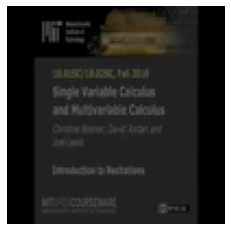

Image with size ( 150 X 150 )


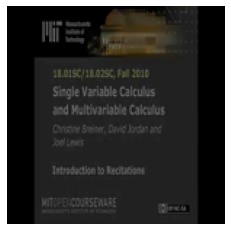

Image with size ( 200 X 200 )


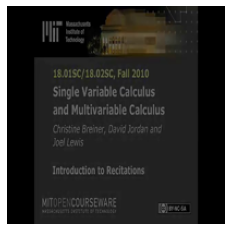

Image with size ( 224 X 224 )


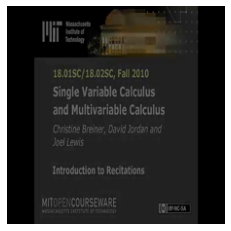

Image with size ( 256 X 256 )


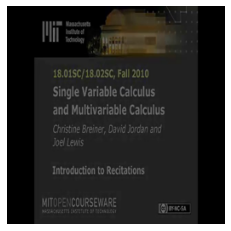

Image with size ( 512 X 512 )


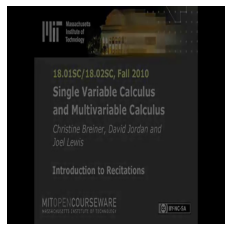

In [11]:
# sample of one data with various resizing
select_file=trainPathMode+train_generator.filenames[2]
for i in [100,150,200,224,256,512]:
    rgba_image = Image.open(select_file)
    resized=rgba_image.resize((i,i))
    print("Image with size (",i,"X",i,")")
    plt.imshow(resized)
    plt.axis("off")
    plt.show()
   

In [12]:
#Using resnet base from keras
baseModel=tf.keras.applications.ResNet50(
    include_top=False,
     weights="imagenet",
    input_tensor=Input(shape=(224,224,3))
)

94773248/94765736 [==============================] - 1s 0us/step


In [13]:
# 
for bl in baseModel.layers:
    bl.trainable=False

In [14]:
# Model defination for the classification
headModel=baseModel.output
headModel=MaxPooling2D(pool_size=(3,3))(headModel)
headModel=Dense(512,activation="relu")(headModel)
headModel=MaxPooling2D(pool_size=(2,2))(headModel)
headModel=Dense(256,activation="relu")(headModel)
headModel=Dense(128,activation="relu")(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dropout(rate=0.6)(headModel)
headModel=Dense(2,activation="softmax")(headModel)

In [15]:
model=Models.Model(inputs=baseModel.input,outputs=headModel)

In [16]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
#Model compilation for training
model.compile(loss="categorical_crossentropy",optimizer=Optimizer.Adam(learning_rate=0.001),metrics=['accuracy','Precision'])

#Defining earlystopping of epoch if no improvement is found
early_stopping = EarlyStopping(monitor="val_loss",patience=6)

In [ ]:
# Fitting the data into the model for training
model_history=model.fit(train_generator,steps_per_epoch=len(train_generator.filenames)//64, validation_data=valid_generator,validation_steps=len(valid_generator.filenames)//64,epochs=50)

Epoch 1/50
48/48 [==============================] - 1056s 22s/step - loss: 1.7229 - accuracy: 0.5149 - precision: 0.5149 - val_loss: 0.7358 - val_accuracy: 0.4922 - val_precision: 0.4922
Epoch 2/50
48/48 [==============================] - 621s 13s/step - loss: 0.8379 - accuracy: 0.4691 - precision: 0.4691 - val_loss: 0.7521 - val_accuracy: 0.5078 - val_precision: 0.5078
Epoch 3/50
48/48 [==============================] - 607s 13s/step - loss: 0.7055 - accuracy: 0.5422 - precision: 0.5422 - val_loss: 0.8048 - val_accuracy: 0.5117 - val_precision: 0.5117
Epoch 4/50
48/48 [==============================] - 608s 13s/step - loss: 0.7118 - accuracy: 0.6129 - precision: 0.6129 - val_loss: 0.7656 - val_accuracy: 0.5078 - val_precision: 0.5078
Epoch 5/50
48/48 [==============================] - 615s 13s/step - loss: 0.7537 - accuracy: 0.6135 - precision: 0.6135 - val_loss: 0.6785 - val_accuracy: 0.5664 - val_precision: 0.5664
Epoch 6/50
48/48 [==============================] - 609s 13s/step - l

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy for Resnet50')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [1]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss for Resnet50 model')
plt.ylim(0.5,3)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

In [2]:
# Test data augmentation and generation
testAugment=ImageDataGenerator(rescale=1./255)
test_generator=testAugment.flow_from_directory(
    testPathmode,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
    )

NameError: ignored

In [ ]:
test_score=model.evaluate(test_generator)

In [ ]:
scores=pd.DataFrame(zip(model.metrics_names,test_score))

In [ ]:
print(scores) # Metrics of Test scores from Model evaluation

In [ ]:
predictions=model.predict(test_generator) # Model prediction over the test data

In [ ]:
print("Total number of prediction is ", len(predictions))

In [ ]:
#
pred_values=[]
for i in range(len(predictions)):
  pred_values.append(features_name[np.argmax(predictions[i])])
act_values=[]
tname=[]
filenames_test=test_generator.filenames
for i in range(len(filenames_test)):
  targets=filenames_test[i].split("/")
  act_values.append(targets[0])
  tname.append(targets[1])



In [ ]:
# Final prediction Dataframe
final_prediction=pd.DataFrame()
final_prediction["ImageName"]=tname
final_prediction["Actual Feature"]=act_values
final_prediction["Predicted Feature"]=pred_values


In [ ]:
# Final prediction output
final_prediction.to_csv("Prediction.csv")
fp.download('Prediction.csv')

In [ ]:
# Traning data output
trainset_details.to_csv("Traning_set_info.csv")
fp.download('Traning_set_info.csv')

In [ ]:
exp_images=[]
exp_data_filename=[]
for i in os.listdir(explicit_data):
     # Reading the image
     exp_data_filename.append(i)
     img =cv2.imread(explicit_data+"//"+i)
     # Normalization of images of training data 
     image = cv2.resize(img,(224,224))
     imagef=cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
     exp_images.append(imagef)


In [ ]:
pred_on_exp_data=model.predict(np.array(exp_images))

In [ ]:
exp_pred_values=[]
for i in range(len(pred_on_exp_data)):
  exp_pred_values.append(features_name[np.argmax(pred_on_exp_data[i])])

In [ ]:
exp_outcome=pd.DataFrame()
exp_outcome["ImageName"]=exp_data_filename
exp_outcome["Predicted Feature"]=exp_pred_values

In [ ]:
exp_outcome["Predicted Feature"].value_counts()

In [ ]:
#Prediction over Unlabeled data:
# Final prediction output
exp_outcome.to_csv("Prediction_unlabeled_resnet.csv")
fp.download('Prediction_unlabeled_resnet.csv')